# Visualize Amazon Customer Reviews Dataset

### Dataset columns:

- `marketplace`: 2-letter country code (in this case all "US").
- `customer_id`: Random identifier that can be used to aggregate reviews written by a single author.
- `review_id`: A unique ID for the review.
- `product_id`: The Amazon Standard Identification Number (ASIN).  `http://www.amazon.com/dp/<ASIN>` links to the product's detail page.
- `product_parent`: The parent of that ASIN.  Multiple ASINs (color or format variations of the same product) can roll up into a single parent parent.
- `product_title`: Title description of the product.
- `product_category`: Broad product category that can be used to group reviews (in this case digital videos).
- `star_rating`: The review's rating (1 to 5 stars).
- `helpful_votes`: Number of helpful votes for the review.
- `total_votes`: Number of total votes the review received.
- `vine`: Was the review written as part of the [Vine](https://www.amazon.com/gp/vine/help) program?
- `verified_purchase`: Was the review from a verified purchase?
- `review_headline`: The title of the review itself.
- `review_body`: The text of the review.
- `review_date`: The date the review was written.

In [1]:
%%bash
pip install -q --upgrade pip
pip install -q pandas==0.23.0
pip install -q numpy==1.14.3
pip install -q matplotlib==3.0.3
pip install -q seaborn==0.8.1
pip install -q PyAthena==1.8.0

In [2]:
# Imports & Settings

import boto3
import botocore
import sagemaker

import numpy as np
import pandas as pd
import seaborn as sns

import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format='retina'

# Get region 
session = boto3.session.Session()
region_name = session.region_name

# Get SageMaker session & default S3 bucket
sagemaker_session = sagemaker.Session()
bucket = sagemaker_session.default_bucket()

# Set Athena database & table 
database_name = 'dsoaws'
table_name = 'amazon_reviews_parquet'


## List all Product Categories

In [3]:
# PyAthena imports
from pyathena import connect
from pyathena.pandas_cursor import PandasCursor
from pyathena.util import as_pandas

In [4]:
# Set S3 staging directory -- this is a temporary directory used for Athena queries
s3_staging_dir = 's3://{0}/athena/staging'.format(bucket)

In [5]:
# Execute query using connection cursor
cursor = connect(region_name=region_name, s3_staging_dir=s3_staging_dir).cursor()

cursor.execute('SELECT DISTINCT product_category \
                FROM {0}.{1} \
                ORDER BY product_category'
               .format(database_name, table_name))

# Load query results into Pandas DataFrame and show results
df_categories = as_pandas(cursor)
df_categories

,product_category
0,Digital_Software
1,Digital_Video_Games


In [6]:
# Store number of categories
num_categories = df_categories.shape[0]
print(num_categories)

2


## Ratings By Product Category

In [7]:
# Execute query using connection cursor
cursor = connect(region_name=region_name, s3_staging_dir=s3_staging_dir).cursor()

cursor.execute('SELECT product_category, \
                    COUNT(star_rating) AS count_star_rating \
                FROM {0}.{1} \
                GROUP BY product_category \
                ORDER BY count_star_rating DESC'
               .format(database_name, table_name))

# Load query results into Pandas DataFrame and show results
df_star_ratings = as_pandas(cursor)
df_star_ratings.head(10)

,product_category,count_star_rating
0,Digital_Video_Games,145431
1,Digital_Software,102084


In [8]:
# Store max ratings
max_ratings = df_star_ratings['count_star_rating'].max()
print(max_ratings)

145431


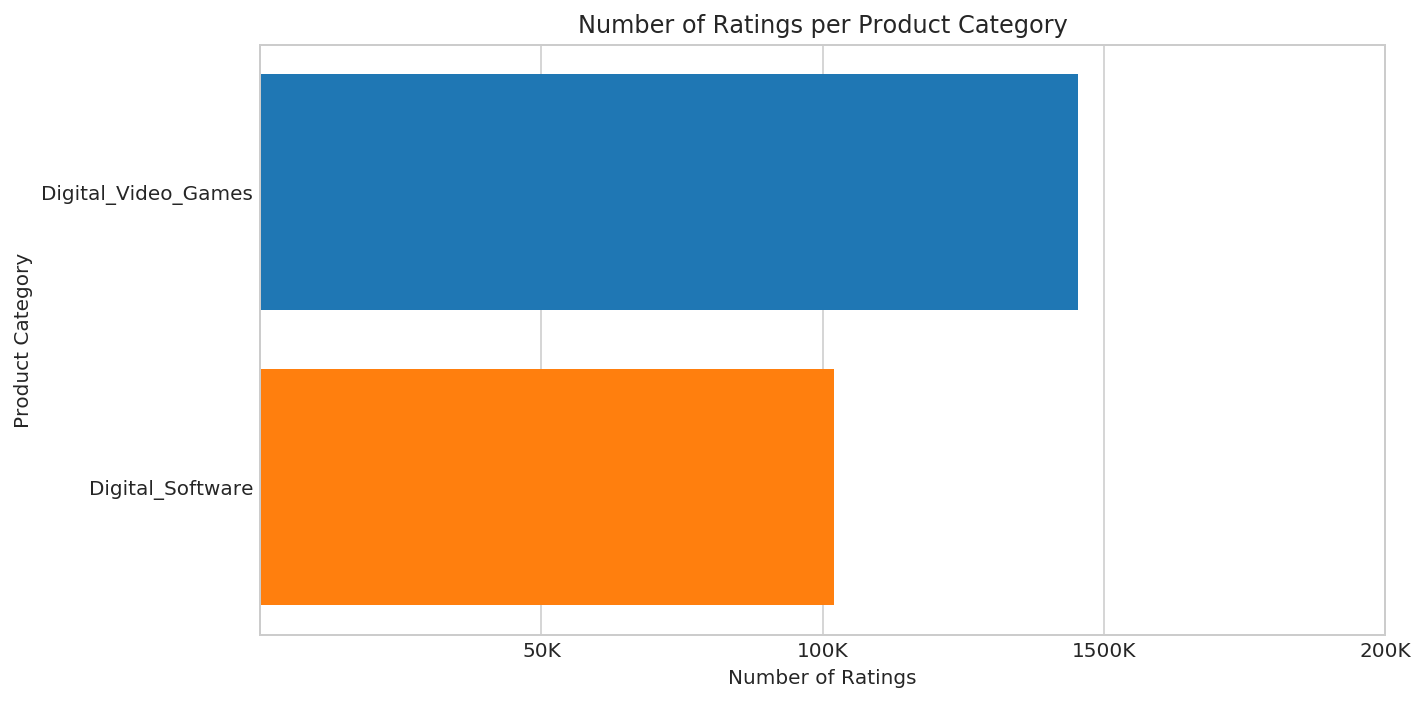

In [9]:
# Set size and style to use
if num_categories > 10:
    plt.figure(figsize=(10,10))
else: 
    plt.figure(figsize=(10,5))

plt.style.use('seaborn-whitegrid')

# Create Seaborn barplot
barplot = sns.barplot(y='product_category', x='count_star_rating', data = df_star_ratings, saturation=1)

# Set title
plt.title("Number of Ratings per Product Category")

# Set x-axis ticks to match scale 
if max_ratings > 200000:
    plt.xticks([100000, 1000000, 5000000, 10000000, 15000000, 20000000], ['100K', '1m', '5m', '10m','15m','20m'])
    plt.xlim(0, 20000000)
elif max_ratings <= 200000:
    plt.xticks([50000, 100000, 150000, 200000], ['50K', '100K', '1500K', '200K'])
    plt.xlim(0, 200000)

plt.xlabel("Number of Ratings")
plt.ylabel("Product Category")

plt.tight_layout()

# Export plot if needed
# plt.savefig('ratings_per_category.png', dpi=300)

# Show the barplot
plt.show(barplot)

## Average Rating by Product Category

In [10]:
# Execute query using connection cursor
cursor = connect(region_name=region_name, s3_staging_dir=s3_staging_dir).cursor()

cursor.execute('SELECT product_category, \
                    AVG(star_rating) AS avg_star_rating \
                FROM {0}.{1} \
                GROUP BY product_category \
                ORDER BY avg_star_rating DESC'
               .format(database_name, table_name))

# Load query results into Pandas DataFrame and show results
df_average_ratings = as_pandas(cursor)
df_average_ratings.head(10)

,product_category,avg_star_rating
0,Digital_Video_Games,3.853126
1,Digital_Software,3.539330


In [11]:
# Set some Seaborn parameters in advance
sns.set_style = 'seaborn-whitegrid'

sns.set(rc={"font.style":"normal",
#            "axes.facecolor":"white",
            "figure.facecolor":"white",
            "figure.titlesize":20,
            "text.color":"black",
            "xtick.color":"black",
            "ytick.color":"black",
            "axes.labelcolor":"black",
            "axes.grid":True,
            'axes.labelsize':10,
#           'figure.figsize':(10.0, 10.0),
            'xtick.labelsize':10,
            'font.size':10,
            'ytick.labelsize':10})

In [12]:
# Helper code to display values on bars

def show_values_barplot(axs, space):
    def _show_on_plot(ax):
        for p in ax.patches:
            _x = p.get_x() + p.get_width() + float(space)
            _y = p.get_y() + p.get_height()
            value = round(float(p.get_width()),2)
            ax.text(_x, _y, value, ha="left")

    if isinstance(axs, np.ndarray):
        for idx, ax in np.ndenumerate(axs):
            _show_on_plot(ax)
    else:
        _show_on_plot(axs)

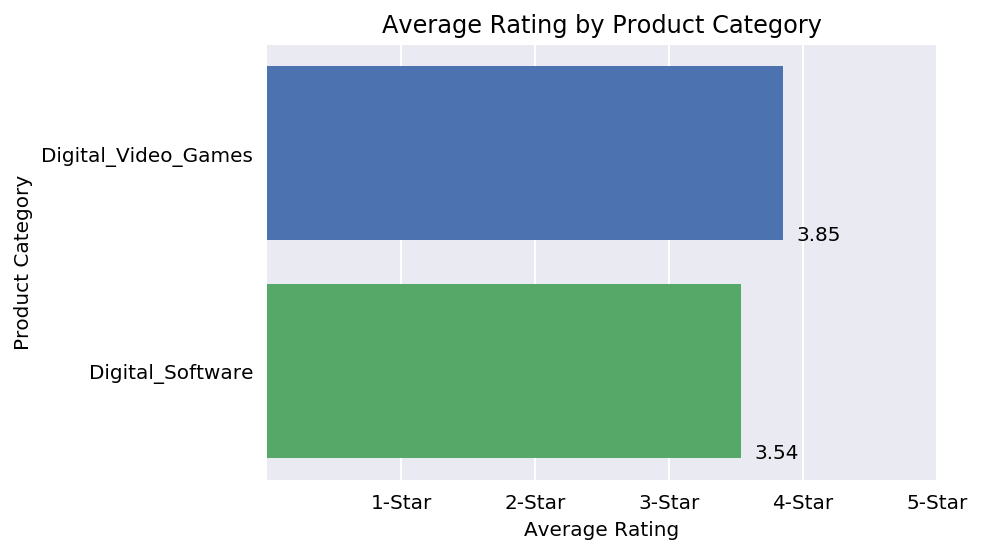

In [13]:
# Plot average ratings per category

# Create plot
barplot = sns.barplot(y='product_category', x='avg_star_rating', data = df_average_ratings, saturation=1)

# Set title and x-axis ticks 
plt.title('Average Rating by Product Category')
plt.xticks([1, 2, 3, 4, 5], ['1-Star', '2-Star', '3-Star','4-Star','5-Star'])

# Helper code to show actual values afters bars 
show_values_barplot(barplot, 0.1)

plt.xlabel("Average Rating")
plt.ylabel("Product Category")

# Export plot if needed
# plt.tight_layout()
# plt.savefig('avg_ratings_per_category.png', dpi=300)

# Show graphic
plt.show(barplot)

## Rating Breakdown by Product Category

### First, calculate standard deviation and square root of number of reviews

In [14]:
# Execute query using connection cursor
cursor = connect(region_name=region_name, s3_staging_dir=s3_staging_dir).cursor()

cursor.execute('SELECT product_category, \
                         AVG(star_rating) AS avg_star_rating, \
                         STDDEV(star_rating) AS stddev_star_rating, \
                         SQRT(COUNT(*)) AS sqrt_count \
                FROM {}.{} \
                GROUP BY product_category \
                ORDER BY avg_star_rating DESC'
               .format(database_name, table_name))

# Load query results into Pandas DataFrame and show results
df_avg_stddev_sqrt = as_pandas(cursor)
df_avg_stddev_sqrt.head(10)

,product_category,avg_star_rating,stddev_star_rating,sqrt_count
0,Digital_Video_Games,3.853126,1.539984,381.354166
1,Digital_Software,3.539330,1.640295,319.505868


### Then, calculate standard deviation mean

In [15]:
# Execute query using connection cursor
cursor = connect(region_name=region_name, s3_staging_dir=s3_staging_dir).cursor()

cursor.execute('SELECT product_category, \
                         AVG(star_rating) AS avg_star_rating, \
                         (STDDEV(star_rating) / SQRT(COUNT(*))) AS sd_mean \
                FROM {}.{} \
                GROUP BY product_category \
                ORDER BY avg_star_rating DESC'
               .format(database_name, table_name))

# Load query results into Pandas DataFrame and show results
df_breakdown_category_avg = as_pandas(cursor)
df_breakdown_category_avg.head(10)

,product_category,avg_star_rating,sd_mean
0,Digital_Video_Games,3.853126,0.004038
1,Digital_Software,3.539330,0.005134


## Number of reviews per star per category

In [16]:
# Execute query using connection cursor
cursor = connect(region_name=region_name, s3_staging_dir=s3_staging_dir).cursor()

cursor.execute('SELECT product_category, \
                         star_rating, \
                         COUNT(*) AS count_reviews \
                FROM {}.{} \
                GROUP BY  product_category, star_rating \
                ORDER BY  product_category, star_rating ASC, count_reviews DESC'
               .format(database_name, table_name))

# Load query results into Pandas DataFrame and show results
df_breakdown_category = as_pandas(cursor)
df_breakdown_category.head(10)

,product_category,star_rating,count_reviews
0,Digital_Software,1,23783
1,Digital_Software,2,6890
2,Digital_Software,3,8308
3,Digital_Software,4,16693
4,Digital_Software,5,46410
5,Digital_Video_Games,1,24970
6,Digital_Video_Games,2,7749
7,Digital_Video_Games,3,11629
8,Digital_Video_Games,4,20406
9,Digital_Video_Games,5,80677


In [17]:
# Create grouped DataFrames by category and by star rating
grouped_category = df_breakdown_category.groupby('product_category')
grouped_star = df_breakdown_category.groupby('star_rating')

# Create sum of ratings per star rating
df_sum = df_breakdown_category.groupby(['star_rating']).sum()
df_sum.head(10)

,count_reviews
star_rating,
1,48753
2,14639
3,19937
4,37099
5,127087


In [18]:
# Calculate total number of star ratings
total = df_sum['count_reviews'].sum()
print(total)

247515


In [19]:
# Create dictionary of product categories and array of star rating distribution per category

distribution = {}
count_reviews_per_star = []
i=0
    
for category, ratings in grouped_category:
    count_reviews_per_star = []
    for star in ratings['star_rating']:
        count_reviews_per_star.append(ratings.get_value(i, 'count_reviews'))
        i=i+1;
    distribution[category] = count_reviews_per_star

# Check if distribution has been created succesfully
print(distribution)


{'Digital_Software': [23783, 6890, 8308, 16693, 46410], 'Digital_Video_Games': [24970, 7749, 11629, 20406, 80677]}


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel/__main__.py:10: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead


In [20]:
# Check if distribution keys are set correctly to product categories
print(distribution.keys())

dict_keys(['Digital_Software', 'Digital_Video_Games'])


In [21]:
# Check if star rating distributions are set correctly
print(distribution.items())

dict_items([('Digital_Software', [23783, 6890, 8308, 16693, 46410]), ('Digital_Video_Games', [24970, 7749, 11629, 20406, 80677])])


### Build array per star across all categories

In [22]:
# Sort distribution by highest average rating per category
sorted_distribution = {}

df_average_ratings.iloc[:,0]
for index, value in df_average_ratings.iloc[:,0].items():
    sorted_distribution[value] = distribution[value]

In [23]:
# Build array per star across all categories
star1 = []
star2 = []
star3 = []
star4 = []
star5 = []

for k in sorted_distribution.keys():
    stars = sorted_distribution.get(k)
    star1.append(stars[0])
    star2.append(stars[1])
    star3.append(stars[2])
    star4.append(stars[3])
    star5.append(stars[4])
               

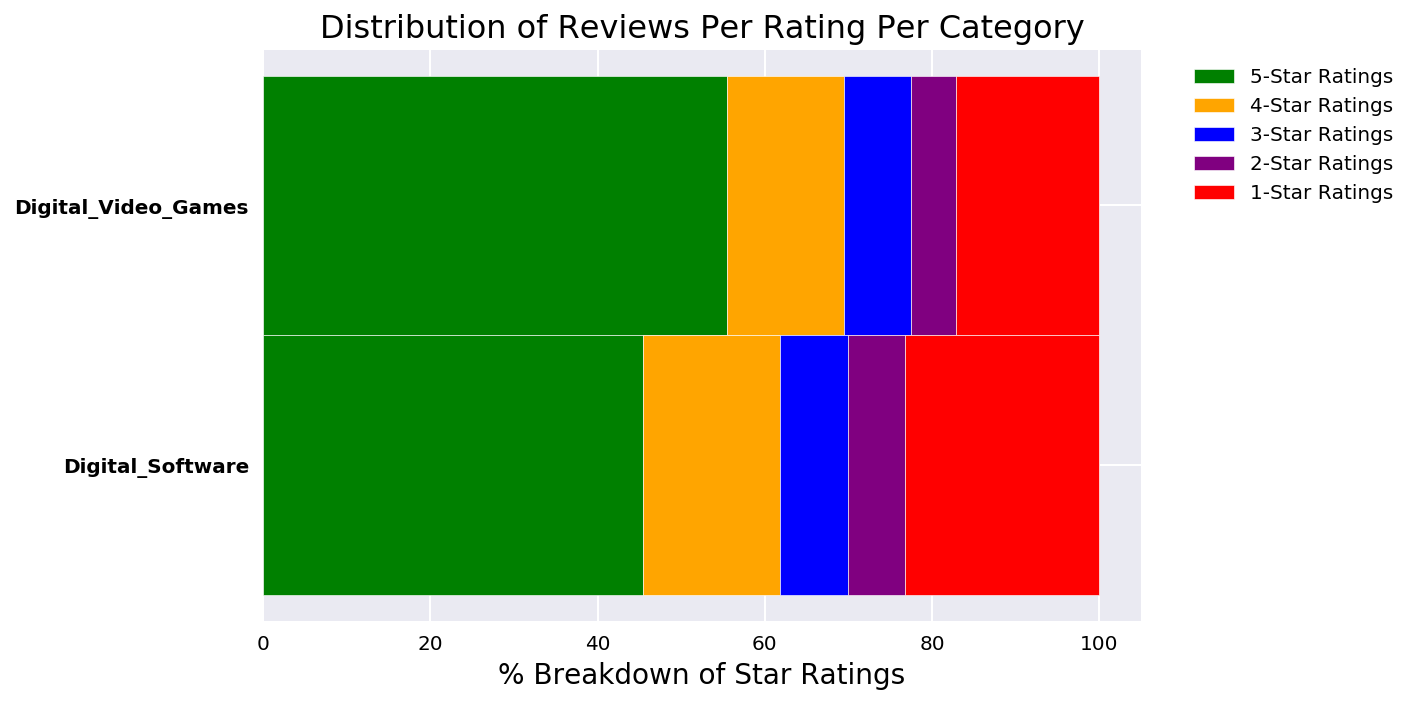

In [24]:
# Plot the distributions of star ratings per product category

categories = sorted_distribution.keys()

total = np.array(star1) + np.array(star2) + np.array(star3) + np.array(star4) + np.array(star5)

proportion_star1 = np.true_divide(star1, total) * 100
proportion_star2 = np.true_divide(star2, total) * 100
proportion_star3 = np.true_divide(star3, total) * 100
proportion_star4 = np.true_divide(star4, total) * 100
proportion_star5 = np.true_divide(star5, total) * 100

# Add colors
colors = ['red', 'purple','blue','orange','green']

# The position of the bars on the x-axis
r = range(len(categories))
barHeight = 1

# Plot bars
if num_categories > 10:
    plt.figure(figsize=(10,10))
else: 
    plt.figure(figsize=(10,5))

ax5 = plt.barh(r, proportion_star5, color=colors[4], edgecolor='white', height=barHeight, label='5-Star Ratings')
ax4 = plt.barh(r, proportion_star4, left=proportion_star5, color=colors[3], edgecolor='white', height=barHeight, label='4-Star Ratings')
ax3 = plt.barh(r, proportion_star3, left=proportion_star5+proportion_star4, color=colors[2], edgecolor='white', height=barHeight, label='3-Star Ratings')
ax2 = plt.barh(r, proportion_star2, left=proportion_star5+proportion_star4+proportion_star3, color=colors[1], edgecolor='white', height=barHeight, label='2-Star Ratings')
ax1 = plt.barh(r, proportion_star1, left=proportion_star5+proportion_star4+proportion_star3+proportion_star2, color=colors[0], edgecolor='white', height=barHeight, label="1-Star Ratings")

plt.title("Distribution of Reviews Per Rating Per Category",fontsize='16')
plt.legend(bbox_to_anchor=(1.04,1), loc="upper left")
plt.yticks(r, categories, fontweight='bold')

plt.xlabel("% Breakdown of Star Ratings", fontsize='14')
plt.gca().invert_yaxis()

plt.tight_layout()
plt.show()


## Translate Ratings into Sentiment

**Attention**: the SQL query below can take a long time on large datasets, hence set a LIMIT if you run it from within the notebook, or execute the query in the Athena Console directly. 

In [25]:
# Execute query using connection cursor      
cursor = connect(region_name=region_name, s3_staging_dir=s3_staging_dir).cursor()

# If rating > 3, sentiment = 1 (positive), else 0 (negative)
cursor.execute('SELECT customer_id, \
                         product_id, \
                         star_rating, \
                         CASE \
                             WHEN star_rating > 3 THEN 1 \
                             ELSE 0 \
                         END \
                AS is_positive_sentiment \
                FROM {}.{} \
                ORDER BY review_id \
                LIMIT 10000'
                .format(database_name, table_name))

# Load query results into Pandas DataFrame and show results
df_sentiment = as_pandas(cursor)
df_sentiment.head(10)

,customer_id,product_id,star_rating,is_positive_sentiment
0,12542307,B00G0DY58O,5,1
1,24999008,B004U1ZB5E,4,1
2,8516496,B004D4YDNE,5,1
3,2558272,B007PVDAAY,1,0
4,28472053,B00FGDDTSQ,5,1
5,21683176,B00DQG8P34,1,0
6,31480414,B00NG7JVSQ,4,1
7,1784943,B00I0FSU86,1,0
8,4394530,B00H9A60O4,5,1
9,19266796,B00GJ2HZ7E,4,1


## Python [Wordcloud](http://amueller.github.io/word_cloud/) Visualization

See the most popular words in the dataset using a Wordcloud visualization.
Attention, the SQL query below can take a long time on large datasets, hence set a LIMIT.

In [26]:
!python -m pip install wordcloud -q

In [27]:
# Execute query using connection cursor     
cursor = connect(region_name=region_name, s3_staging_dir=s3_staging_dir).cursor()

cursor.execute('SELECT review_body, \
                         CASE \
                             WHEN star_rating > 3 THEN 1 \
                             ELSE 0 \
                         END \
                AS is_positive_sentiment \
                FROM {}.{} \
                ORDER BY review_id \
                LIMIT 10000'
                .format(database_name, table_name))

df_reviews = as_pandas(cursor)
df_reviews.head(10)

,review_body,is_positive_sentiment
0,H & R Block takes you step by step. If you ta...,1
1,This one has a somewhat interesting storyline....,1
2,Awesome fast download thank you amazon.com lov...,1
3,It actually sucks. It doesn't accept any gamep...,0
4,Very satisfied!,1
5,WHAT THE HELL! IT CAN ONLY BE USED TO RECORD A...,0
6,"I liked it, very easy to use. The one flaw is ...",1
7,it dont work money back plz,0
8,Free and it works.,1
9,"I liked this package a lot, but I should have ...",1


Note: To remove HTML markup like the word `br` in the `review_body`, use [BeautifulSoup](https://www.crummy.com/software/BeautifulSoup/bs4/doc/).

In [28]:
import bs4
df_reviews['review_body'] = df_reviews['review_body'].apply(lambda x: bs4.BeautifulSoup(x, 'lxml').get_text())
df_reviews

,review_body,is_positive_sentiment
0,H & R Block takes you step by step. If you ta...,1
1,This one has a somewhat interesting storyline....,1
2,Awesome fast download thank you amazon.com lov...,1
3,It actually sucks. It doesn't accept any gamep...,0
4,Very satisfied!,1
5,WHAT THE HELL! IT CAN ONLY BE USED TO RECORD A...,0
6,"I liked it, very easy to use. The one flaw is ...",1
7,it dont work money back plz,0
8,Free and it works.,1
9,"I liked this package a lot, but I should have ...",1


In [29]:
from wordcloud import WordCloud, STOPWORDS

def plot_wordcloud(text, mask=None, max_words=200, max_font_size=150, figure_size=(20.0,15.0), 
                   title = None, title_size=40, image_color=False):
    stopwords = set(STOPWORDS)

    wordcloud = WordCloud(background_color='gray',
                    stopwords = stopwords,
                    max_words = max_words,
                    max_font_size = max_font_size, 
                    random_state = 50,
                    width=800, 
                    height=400,
                    mask = mask)
    wordcloud.generate(str(text))
    
    plt.figure(figsize=figure_size)
    if image_color:
        image_colors = ImageColorGenerator(mask);
        plt.imshow(wordcloud.recolor(color_func=image_colors), interpolation="bilinear");
        plt.title(title, fontdict={'size': title_size,  
                                   'verticalalignment': 'bottom'})
    else:
        plt.imshow(wordcloud);
        plt.title(title, fontdict={'size': title_size, 'color': 'black', 
                                   'verticalalignment': 'bottom'})
    plt.axis('off');
    plt.tight_layout()  

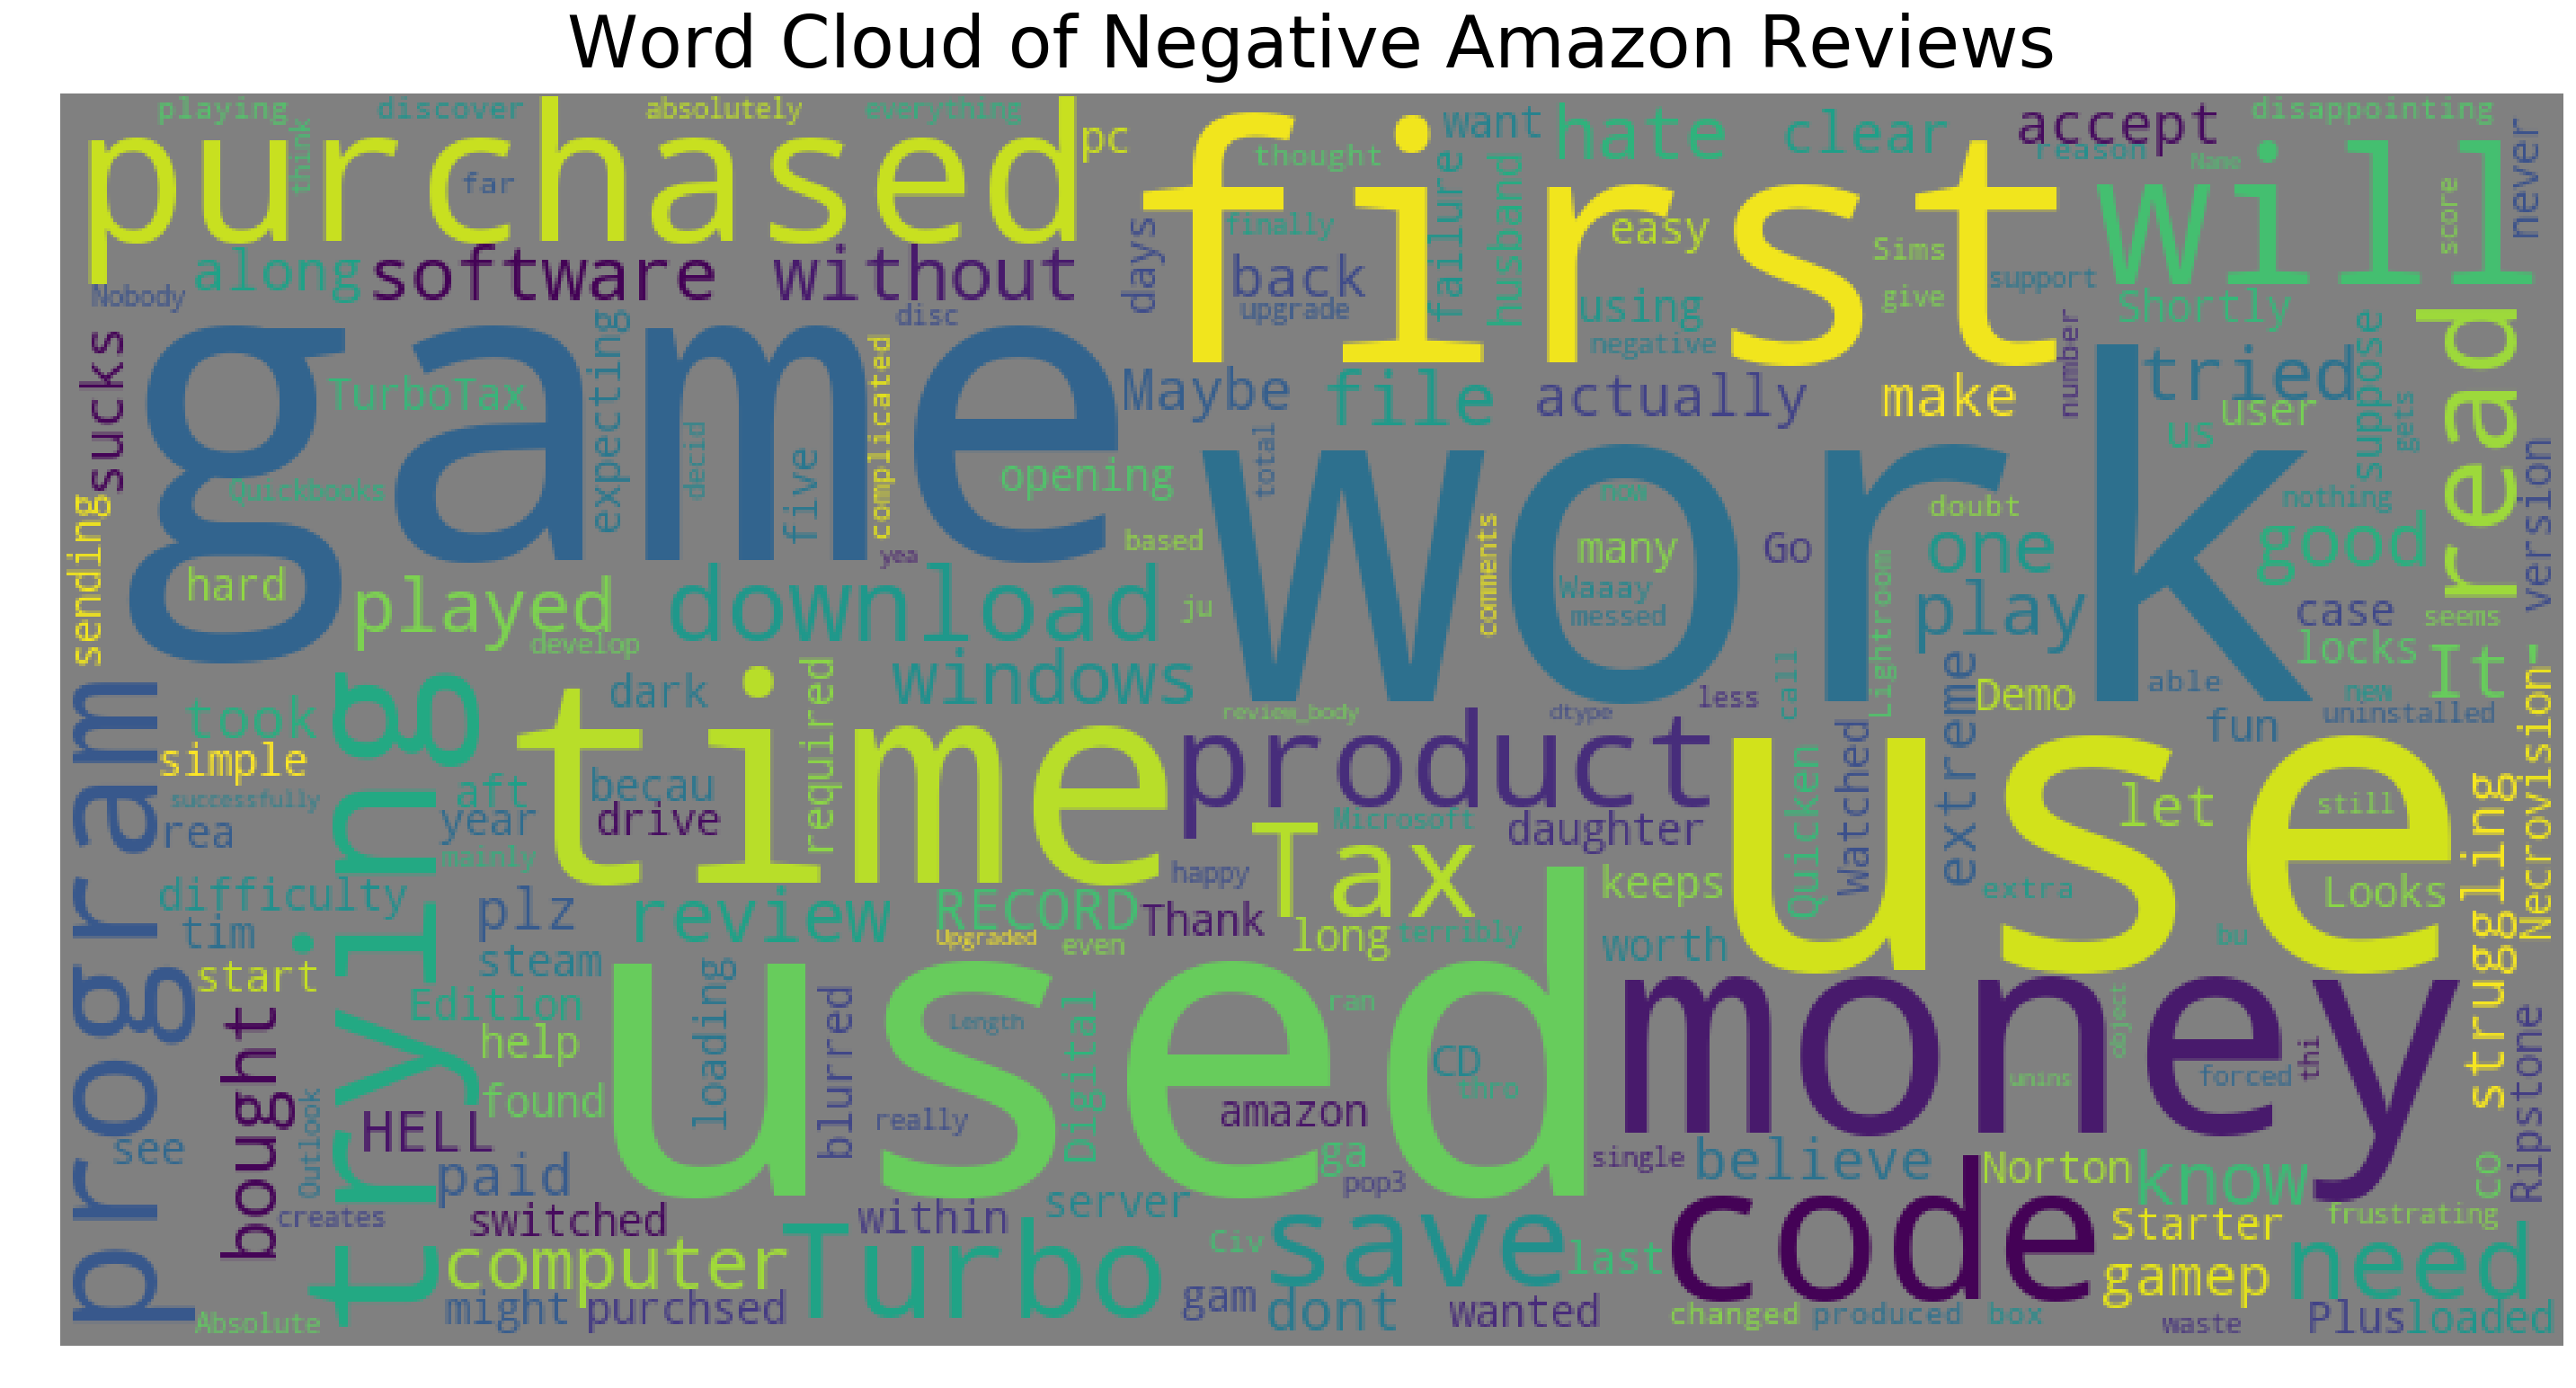

In [30]:
plot_wordcloud(df_reviews.query('is_positive_sentiment == 0')['review_body'], title="Word Cloud of Negative Amazon Reviews")

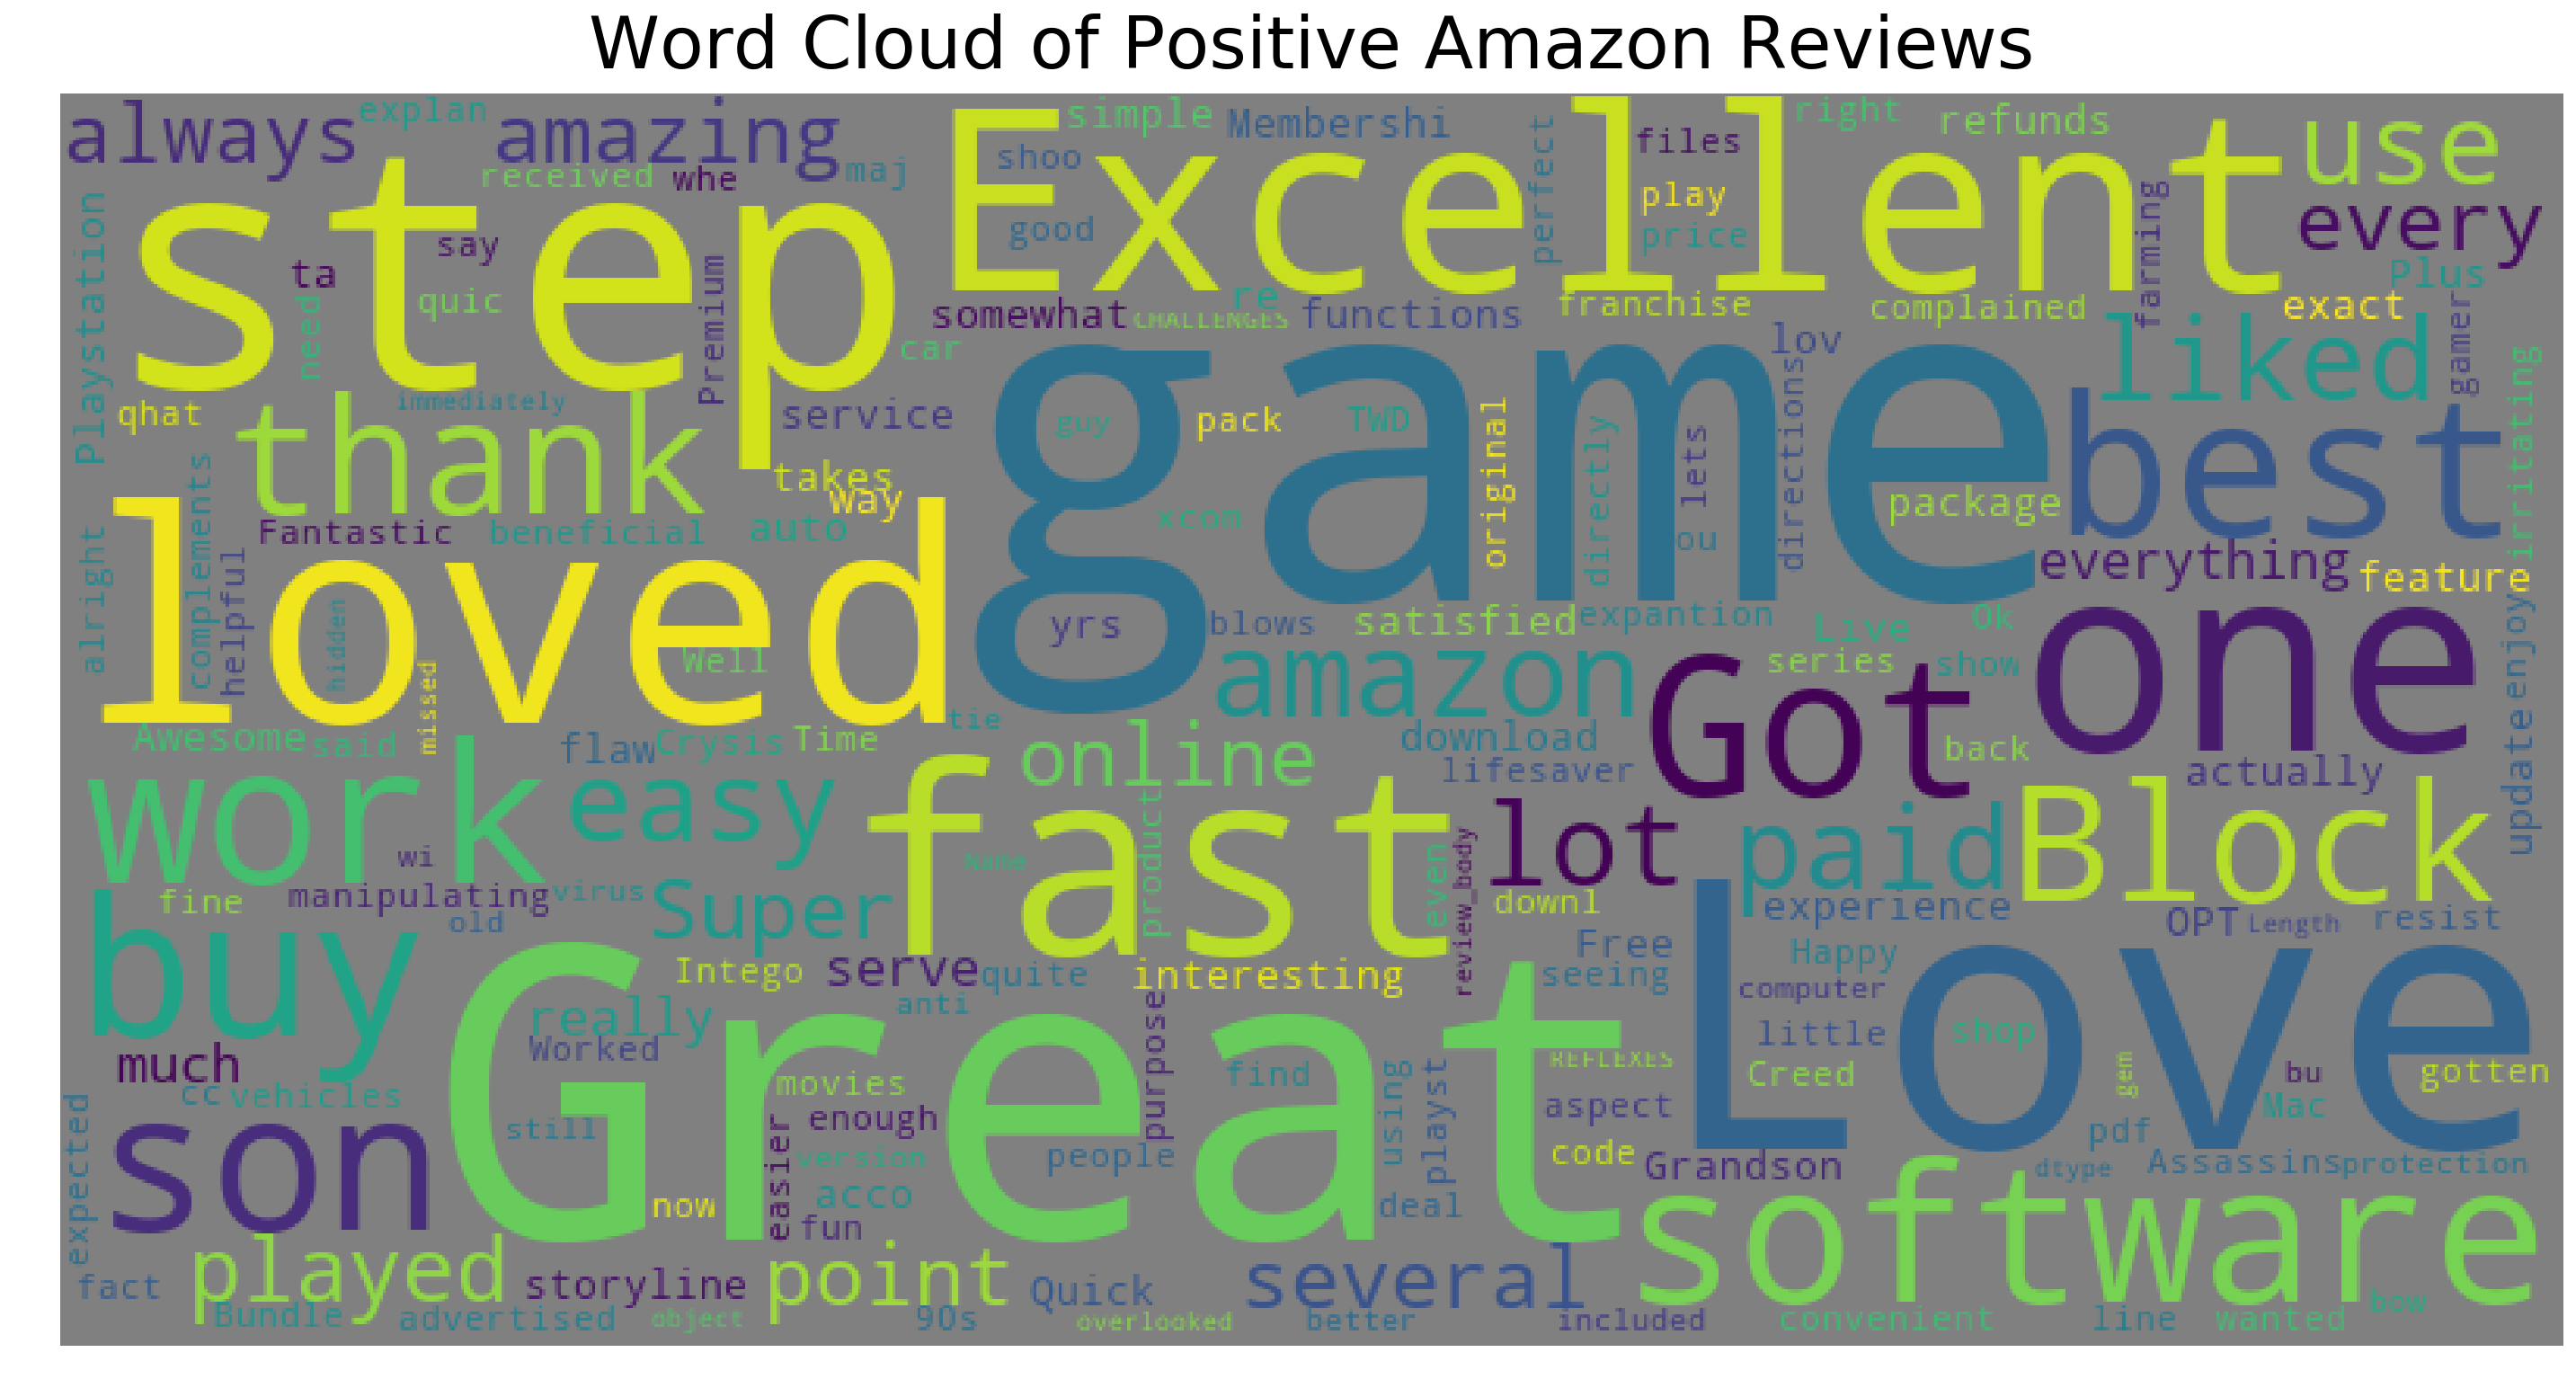

In [31]:
plot_wordcloud(df_reviews.query('is_positive_sentiment == 1')['review_body'], title="Word Cloud of Positive Amazon Reviews")

## Let's do some further text analysis
* Number of words
* Number of unique words
* Number of chars in the text
* Number of stopwords
* Number of punctuations
* Average word length

In [32]:
import string

df_reviews['num_words'] = df_reviews['review_body'].apply(lambda x: len(str(x).split()))

df_reviews['num_unique_words'] = df_reviews['review_body'].apply(lambda x: len(set(str(x).split())))

df_reviews['num_chars'] = df_reviews['review_body'].apply(lambda x: len(str(x)))

df_reviews['num_stopwords'] = df_reviews['review_body'].apply(lambda x: len([w for w in str(x).lower().split() if w in STOPWORDS]))

df_reviews['num_punctuations'] = df_reviews['review_body'].apply(lambda x: len([c for c in str(x) if c in string.punctuation]) )

df_reviews['mean_word_len'] = df_reviews['review_body'].apply(lambda x: np.mean([len(w) for w in str(x).split()]))

In [33]:
df_reviews.head(5)

,review_body,is_positive_sentiment,num_words,num_unique_words,num_chars,num_stopwords,num_punctuations,mean_word_len
0,H & R Block takes you step by step. If you ta...,1,41,37,206,21,5,4.024390
1,This one has a somewhat interesting storyline....,1,20,19,120,11,4,5.000000
2,Awesome fast download thank you amazon.com lov...,1,8,8,51,1,2,5.500000
3,It actually sucks. It doesn't accept any gamep...,0,86,67,431,46,22,4.023256
4,Very satisfied!,1,2,2,15,1,1,7.000000


In [34]:
df_reviews.describe()

,is_positive_sentiment,num_words,num_unique_words,num_chars,num_stopwords,num_punctuations,mean_word_len
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,0.666900,64.008000,45.343700,350.535500,31.218900,10.595500,4.496793
std,0.471346,123.702078,58.575733,693.728027,59.944148,22.846581,0.875057
min,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000,1.000000
25%,0.000000,20.000000,18.000000,98.000000,8.000000,2.000000,4.062500
50%,1.000000,31.000000,27.000000,165.000000,15.000000,5.000000,4.386364
75%,1.000000,68.000000,54.000000,365.000000,34.000000,11.000000,4.738231
max,1.000000,3102.000000,1103.000000,17436.000000,1463.000000,635.000000,20.000000


### Truncate extreme values

In [35]:
df_reviews = df_reviews.query('num_words <= 500 and num_punctuations < 500')

### Let's plot number of words, number of characters and number of punctuations in each class using Violin plots

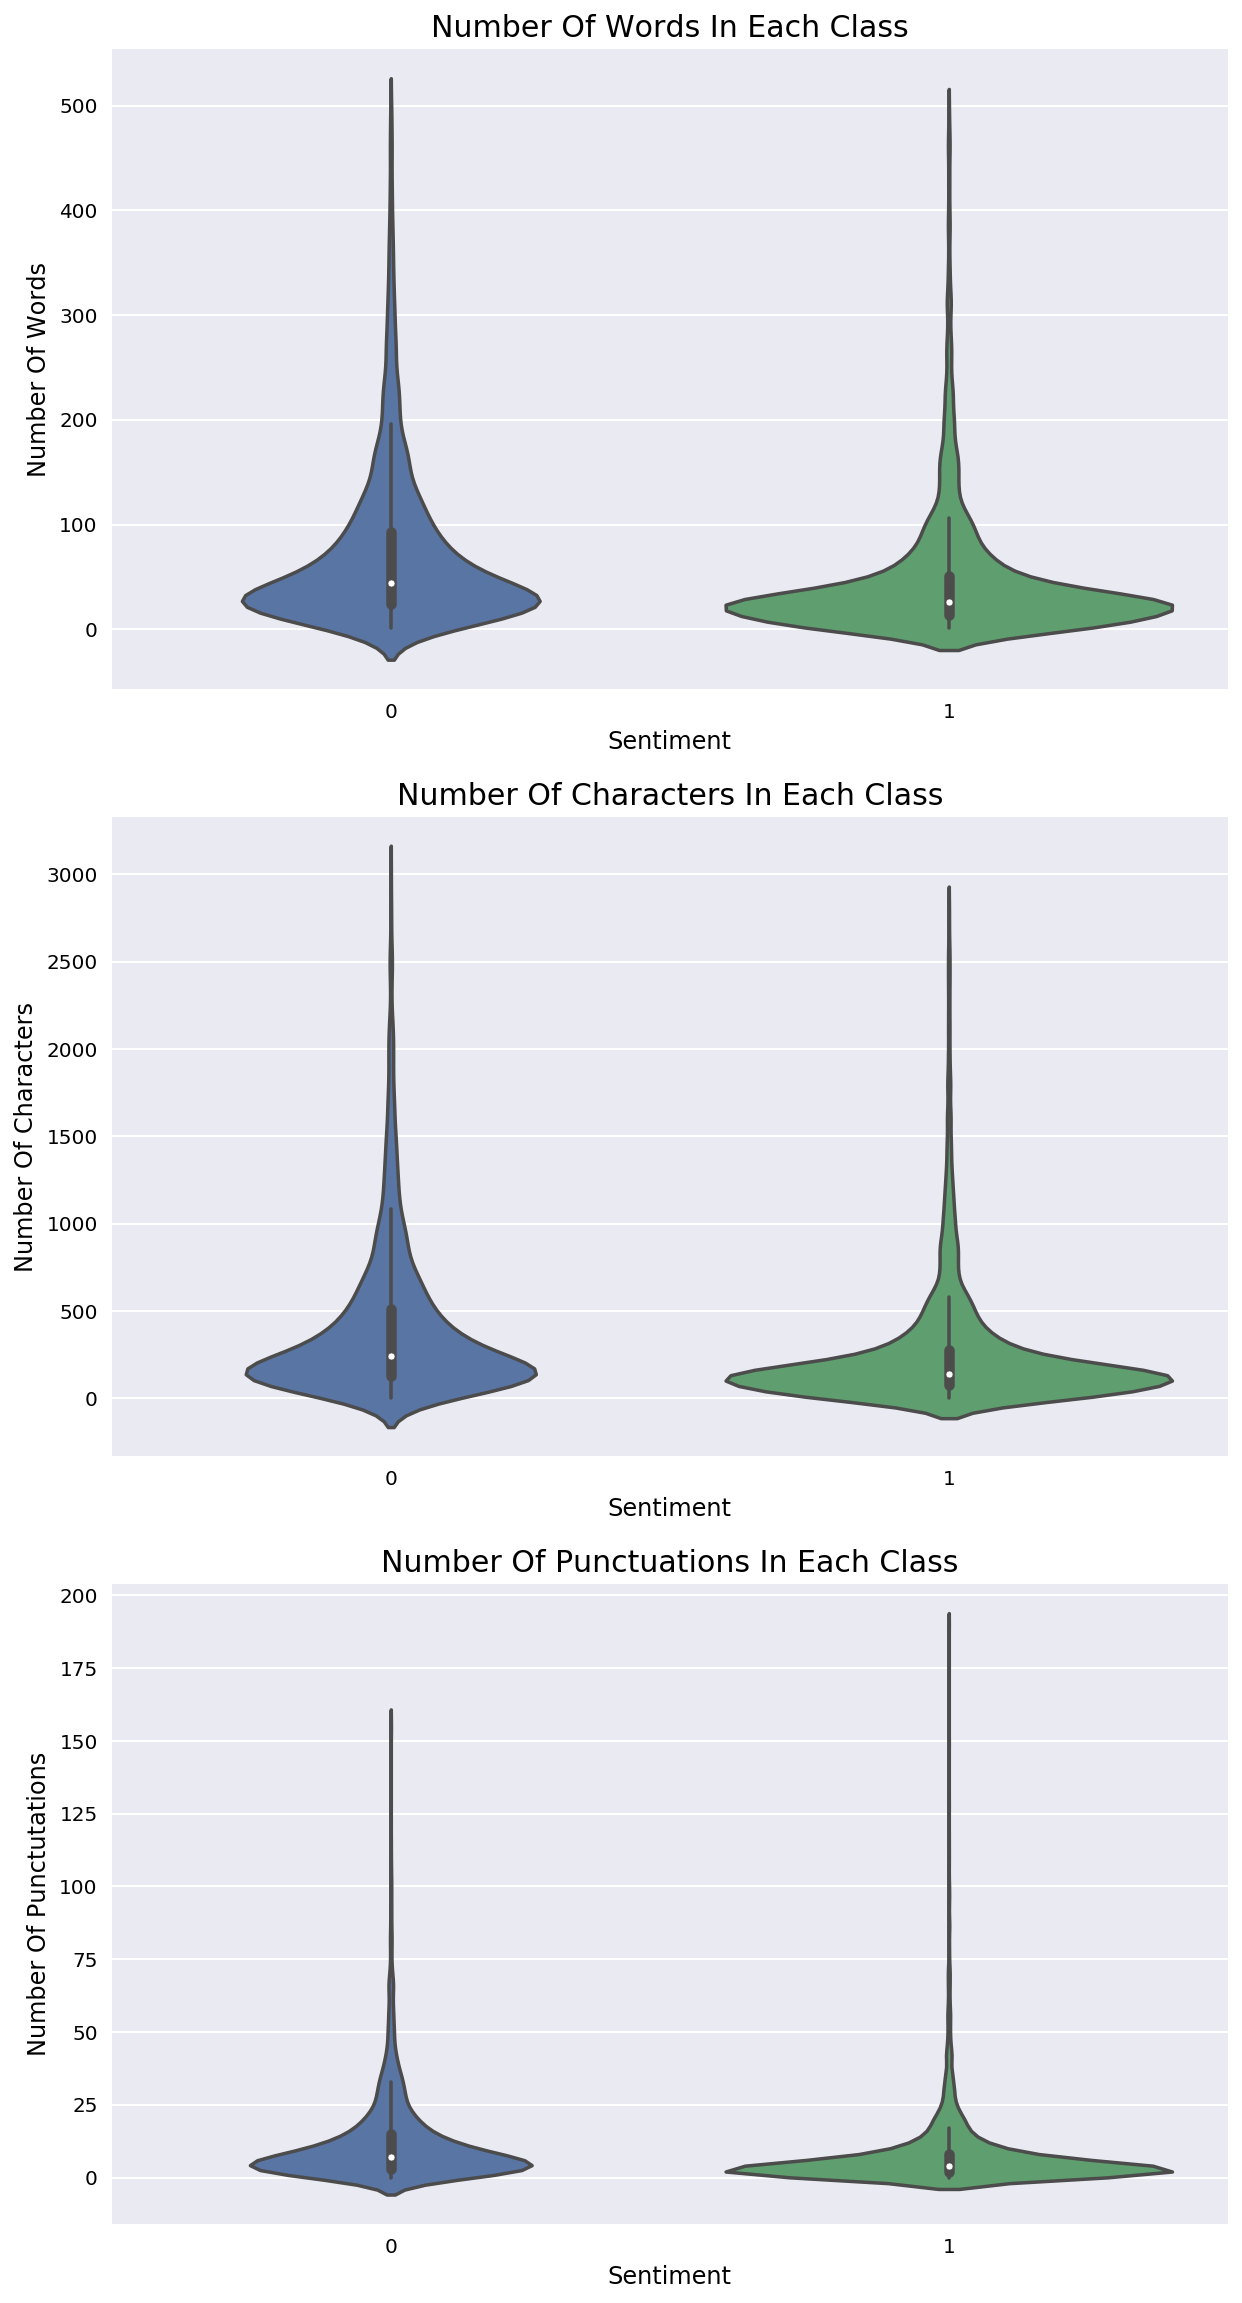

In [36]:
f, axes = plt.subplots(3, 1, figsize=(10,20))

sns.violinplot(x='is_positive_sentiment', y='num_words', data=df_reviews, ax=axes[0])
axes[0].set_xlabel('Sentiment', fontsize=12)
axes[0].set_ylabel('Number Of Words', fontsize=12)
axes[0].set_title("Number Of Words In Each Class", fontsize=15)

sns.violinplot(x='is_positive_sentiment', y='num_chars', data=df_reviews, ax=axes[1])
axes[1].set_xlabel('Sentiment', fontsize=12)
axes[1].set_ylabel('Number Of Characters', fontsize=12)
axes[1].set_title("Number Of Characters In Each Class", fontsize=15)

sns.violinplot(x='is_positive_sentiment', y='num_punctuations', data=df_reviews, ax=axes[2])
axes[2].set_xlabel('Sentiment', fontsize=12)
axes[2].set_ylabel('Number Of Punctutations', fontsize=12)
axes[2].set_title("Number Of Punctuations In Each Class", fontsize=15)
plt.show()

### Start thinking about balancing positive vs. negative reviews

1    6604
0    3286
Name: is_positive_sentiment, dtype: int64


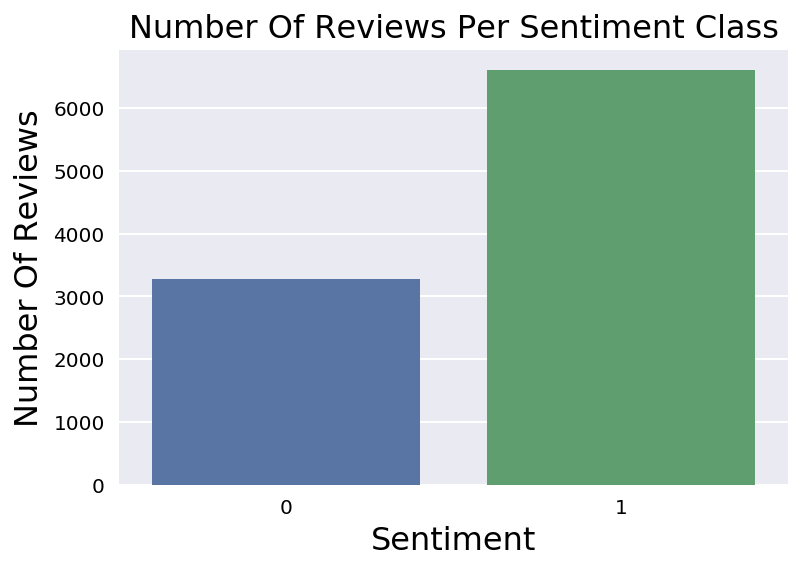

In [37]:
# Count number of reviews per sentiment class
print(df_reviews['is_positive_sentiment'].value_counts())

# Create Plot
plot = sns.countplot(x='is_positive_sentiment', data=df_reviews)
plt.xlabel("Sentiment", fontsize=16)
plt.ylabel("Number Of Reviews", fontsize=16)
plt.title("Number Of Reviews Per Sentiment Class", fontsize=16)

plt.show(plot)

### Handling imbalanced datasets

Here you can see we have a larger number of `positive` samples vs. `negative` ones. There are a number of techniques to blance this dataset out and the two most popular approaches are to either under-sample or over-sample. With under sampling you remove rows to balance the dataset out and in over sampling you can duplicate entries in the daatset which could lead to overfitting. This discussion is beyond the scope of this lab. You will under sample the data to balance the dataset but you can find more information [here]().

1    3286
0    3286
Name: is_positive_sentiment, dtype: int64


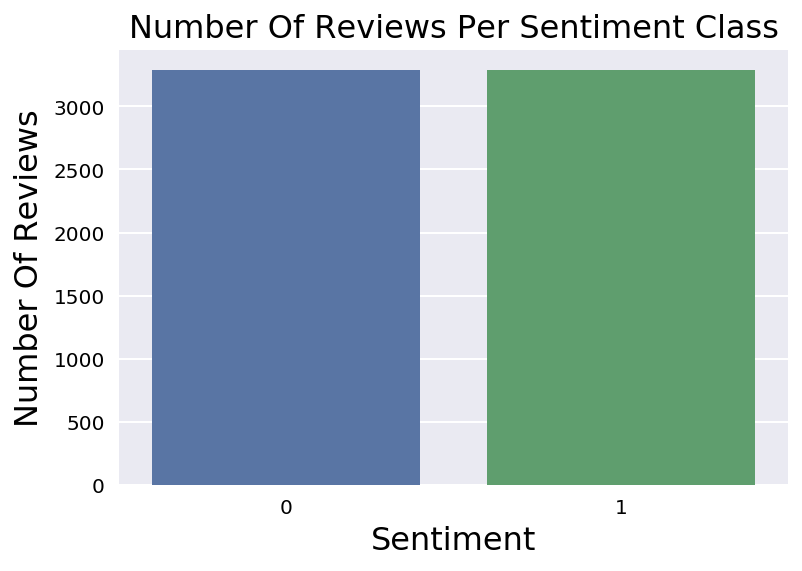

In [38]:
from sklearn.utils import resample

positive = df_reviews[df_reviews['is_positive_sentiment']==1]
negative = df_reviews[df_reviews['is_positive_sentiment']==0]

positive_downsampled = resample(positive,
                                replace = False, # sample without replacement
                                n_samples = len(negative), # match minority n
                                random_state = 27) # reproducible results

# combine minority and downsampled majority
downsampled = pd.concat([positive_downsampled, negative])

# checking counts
print(downsampled['is_positive_sentiment'].value_counts())

# Create Plot
plot = sns.countplot(x='is_positive_sentiment', data=downsampled)
plt.xlabel("Sentiment", fontsize=16)
plt.ylabel("Number Of Reviews", fontsize=16)
plt.title("Number Of Reviews Per Sentiment Class", fontsize=16)

plt.show(plot)

### Create Test, Train, and Validation Datasets

Depending on the framework you are leveraging in your AI/ML workloads you may decide to split the data into test, train, and validate splits before uploading to S3. You can leverage some built in functions in the sklearn package to do the split. To learn more about the sklearn framework click [here](https://scikit-learn.org/stable/).

In [39]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(downsampled, test_size=0.2, random_state=0)
test, validate = train_test_split(test, test_size=0.5, random_state=0)

print(f'Number of training examples: {len(train.index)}')
print(f'Number of testing examples: {len(test.index)}')
print(f'Number of validation examples: {len(validate.index)}')


Number of training examples: 5257
Number of testing examples: 657
Number of validation examples: 658


### Visualize the Train, Test, and Validation Split

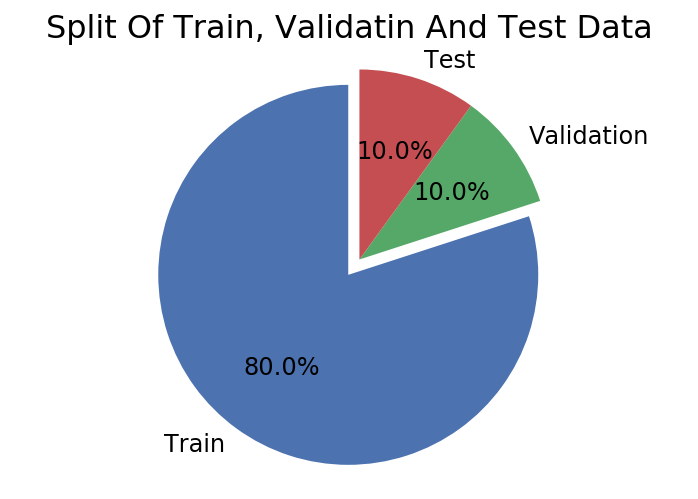

In [40]:
# Pie chart, where the slices will be ordered and plotted counter-clockwise:

labels = ['Train', 'Validation', 'Test']
sizes = [len(train.index), len(validate.index), len(test.index)]
explode = (0.1, 0, 0)  

fig1, ax1 = plt.subplots()

ax1.set_title("Split Of Train, Validatin And Test Data", fontsize=16)
ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%', startangle=90, textprops={'fontsize': 12})

# Equal aspect ratio ensures that pie is drawn as a circle.
ax1.axis('equal')  
plt.show()

## Optional - SQL Magic in Jupyter Notebooks

You can use the built-in functionality in Jupyter to create shortcut magic commands to fit your needs. Here we will use the pyathena library like above to query the review data, but this time we will encapsulate the call in the Jupyter magic command.

In [41]:
import pyathena
from pyathena.util import as_pandas

from IPython.core import magic_arguments
from IPython.core.magic import cell_magic, Magics, magics_class


def query_athena(sql, region_name, s3_staging_dir):
    cursor = pyathena.connect(
        region_name=region_name,
        s3_staging_dir="{}".format(s3_staging_dir)).cursor()
    cursor.execute(sql)
    return cursor

@magics_class
class AthenaMagics(Magics):
    s3_staging_dir = None
    region_name = None

    
    def parse_args(self, line):
        args = magic_arguments.parse_argstring(self.athena, line)

        # s3 staging directory
        if args.s3_staging_dir is None and self.s3_staging_dir is None:
            raise ValueError("s3_staging_dir for Athena should be set")
        if args.s3_staging_dir is not None:
            self.s3_staging_dir = args.s3_staging_dir
 
        # region name
        if args.region_name is None and self.region_name is None:
            raise ValueError("region_name for Athena should be set")
        if args.region_name is not None:
            self.region_name = args.region_name
 
    @cell_magic
    @magic_arguments.magic_arguments()
    @magic_arguments.argument('--s3_staging_dir', '-s',
        help='s3 path required by athena for writing query results (e.g. s3://your/staging/dir)'
    )
    @magic_arguments.argument('--region_name', '-r',
        help='aws region name (e.g. us-west-2)'
    )
    def athena(self, line='', cell=None):
        self.parse_args(line)
        cursor = query_athena(cell, self.region_name, self.s3_staging_dir)
        return as_pandas(cursor)

    
ip = get_ipython()
ip.register_magics(AthenaMagics)

### Use the `%%athena` magic to query data registered in your Glue Data Catalog.

In [42]:
%%athena --region_name $region_name --s3_staging_dir $s3_staging_dir

select * from dsoaws.amazon_reviews_parquet limit 10;

,marketplace,customer_id,review_id,product_id,product_parent,product_title,star_rating,helpful_votes,total_votes,vine,verified_purchase,review_headline,review_body,year,review_date,product_category
0,US,41754720,R19OFJV91M7D8X,B000YMR61A,141393130,TurboTax Deluxe Federal + State 2007,2,12,13,N,N,"Easy to use, 1 comment 1 serious problem",I chose the deluxe version CD because of mortg...,2008,2008-02-11,Digital_Software
1,US,51669529,R1I6G894K5AGG5,B000YMR61A,141393130,TurboTax Deluxe Federal + State 2007,4,6,9,N,N,Schedule C IS for business- figures it would ...,"Schedule C IS for business, so figures it wou...",2008,2008-02-08,Digital_Software
2,US,24731012,R17OE43FFEP81I,B000YMR5X4,234295632,TurboTax Premier Federal + State 2007,2,9,16,N,N,Hassel to download,I wish that companies can test several scenari...,2008,2008-02-05,Digital_Software
3,US,16049580,R15MGDDK63B52Z,B000YMR61A,141393130,TurboTax Deluxe Federal + State 2007,3,14,14,N,N,beware of vista,i just installed turbotax deluxe 2007. If you ...,2008,2008-02-05,Digital_Software
4,US,46098046,R1GGJJA2R68033,B000YMNI2Q,847631772,TurboTax Basic 2007,1,54,60,N,N,don't waste your money,The description mentions that you can use this...,2008,2008-01-26,Digital_Software
5,US,47735778,R10XR500YAQQR3,B00H9A60O4,608720080,Avast Free Antivirus 2015 [Download],5,0,0,N,N,Excellent value,"It was easy to install,easy to update either m...",2014,2014-07-28,Digital_Software
6,US,12817770,R1T0U8K2TN3DC1,B00FN4G4P8,436875336,Aiseesoft Blu-ray Player [Download],2,1,1,N,N,"Not worth the money, but plays videos.",Terrible software. The only reason to get it i...,2014,2014-07-28,Digital_Software
7,US,13093149,RUI7VUF7ZWV9Z,B00E7X9RUK,109813655,Quicken Deluxe 20,3,0,0,N,Y,Three Stars,Liked my Quicken 2007 better. 2014 too busy fo...,2014,2014-07-28,Digital_Software
8,US,14593298,R13HO1K1FITKQJ,B00FFIO0NA,386795082,"TurboTax Premier Fed, Efile and State 2013",3,0,0,N,Y,"Federal great, State forms had issues, had to ...",State will not e-file no mater what. Huge disa...,2014,2014-07-28,Digital_Software
9,US,2822352,RXT9AGQM2LJFW,B00FGDEPDY,991059534,Norton Internet Security 1 User 3 Licenses,4,0,0,N,Y,"Good Product . Wait for deal price , u wont re...",Nice. Got a good deal right around the time wh...,2014,2014-07-28,Digital_Software
